<a href="https://colab.research.google.com/github/jellydaniellie/cs6501-project/blob/main/Project1Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files

uploaded_files = files.upload()
chrome_history_file = "ShainaHistory.json"
youtube_history_file = "search-history copy.html"

# Chrome Data
with open(chrome_history_file, "r") as f:
    chrome_data = json.load(f)

chrome_df = pd.DataFrame(chrome_data["Browser History"])
chrome_df["datetime"] = pd.to_datetime(chrome_df["time_usec"] / 1000, unit="ms")
print(chrome_df.head())
print(f"Total Chrome entries: {len(chrome_df)}")

# Youtube Data
with open(youtube_history_file, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

entries = soup.find_all("div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1")

timestamps = []
video_titles = []

for entry in entries:
    text_lines = entry.get_text(separator="\n").split("\n")
    video_link_tag = entry.find("a")

    for line in text_lines:
        line = line.replace("\u202F", " ")
        match = re.search(r'([A-Za-z]{3} \d{1,2}, \d{4}, \d{1,2}:\d{2}(:\d{2})? [APM]{2})', line)
        if match:
            try:
                timestamp_format = "%b %d, %Y, %I:%M:%S %p" if ":" in match.group(0)[-8:] else "%b %d, %Y, %I:%M %p"
                timestamp = datetime.strptime(match.group(0), timestamp_format)
                timestamps.append(timestamp)
                video_titles.append(video_link_tag.text.strip() if video_link_tag else "Unknown")
            except ValueError:
                continue

youtube_df = pd.DataFrame({"datetime": timestamps, "video_title": video_titles})
print(youtube_df.head(), f"\nTotal entries extracted: {len(youtube_df)}")

# Combined Google Takeout Data
activity_df = pd.concat([chrome_df[["datetime"]], youtube_df[["datetime"]]])
activity_df = activity_df.sort_values(by="datetime").reset_index(drop=True)
activity_df["date"] = activity_df["datetime"].dt.date

print(activity_df.head())
print(f"Total Combined Activity Entries: {len(activity_df)}")

print(f"Activity Data Range: {activity_df['datetime'].min()} to {activity_df['datetime'].max()}")



Saving ShainaHistory.json to ShainaHistory.json
Saving watch-history copy.html to watch-history copy.html
Saving search-history copy.html to search-history copy.html
                          favicon_url page_transition_qualifier  \
0  https://www.google.com/favicon.ico           CLIENT_REDIRECT   
1  https://www.google.com/favicon.ico           CLIENT_REDIRECT   
2  https://www.google.com/favicon.ico           CLIENT_REDIRECT   
3                                               CLIENT_REDIRECT   
4                                               CLIENT_REDIRECT   

                           title  \
0                 Google Takeout   
1                 Google Takeout   
2                 Data & privacy   
3                 Data & privacy   
4  Google Takeout Sleep Analysis   

                                                 url         time_usec  \
0                        https://takeout.google.com/  1739512357694584   
1                        https://takeout.google.com/  173951235677

# **SLEEP PREDICTION METHOD**

In [16]:
# Define bedtime and wake-up ranges
BEDTIME_START = 17  # 5 PM
BEDTIME_END = 5  # 5 AM
WAKEUP_MIN = 0  # 12 AM (extended range)
WAKEUP_MAX = 15  # 3 PM
MIN_SLEEP_HOURS = 2
MAX_SLEEP_HOURS = 14


sleep_predictions = {}

for date in activity_df["datetime"].dt.date.unique():
    daily_data = activity_df[activity_df["datetime"].dt.date == date].sort_values(by="datetime")

    # Step 1: Night Time Sleep Detection
    night_activity = daily_data[
        (daily_data["datetime"].dt.hour >= BEDTIME_START) |
        (daily_data["datetime"].dt.hour < BEDTIME_END)
    ]
    last_activity = night_activity["datetime"].max() if not night_activity.empty else None

    next_day_data = activity_df[activity_df["datetime"].dt.date == (date + timedelta(days=1))]
    morning_activity = next_day_data[
        (next_day_data["datetime"].dt.hour >= WAKEUP_MIN) &
        (next_day_data["datetime"].dt.hour <= WAKEUP_MAX)
    ]
    first_activity = morning_activity["datetime"].min() if not morning_activity.empty else None

    if last_activity is not None and first_activity is not None:
        sleep_duration = (first_activity - last_activity).total_seconds() / 3600

        if MIN_SLEEP_HOURS <= sleep_duration <= MAX_SLEEP_HOURS:
            assigned_date = last_activity.date() - timedelta(days=1) if last_activity.hour < 17 else last_activity.date()

            # Store result in dictionary
            sleep_predictions[assigned_date] = {
                "Predicted Sleep Start": last_activity,
                "Predicted Sleep End": first_activity,
                "Predicted Sleep Duration (hrs)": round(sleep_duration, 2),
                "Method": "Nighttime"
            }

    # Step 2: Longest Inactivity Gap (Fallback)
    sleep_start = None
    sleep_end = None
    max_gap = timedelta(hours=MIN_SLEEP_HOURS)
    longest_gap = timedelta(0)  # the absolute longest gap
    longest_sleep_start = None
    longest_sleep_end = None


    for i in range(len(daily_data) - 1):
        current_time = daily_data.iloc[i]["datetime"]
        next_time = daily_data.iloc[i + 1]["datetime"]
        gap = next_time - current_time

        # Track the longest gap overall
        if gap > longest_gap:
          longest_gap = gap
          longest_sleep_start = current_time
          longest_sleep_end = next_time

        # Prefer gaps at least MIN_SLEEP_HOURS long
        if gap >= max_gap:
          sleep_start = current_time
          sleep_end = next_time
          max_gap = gap  # update the max found so far

    # use longest gap if needed
    if sleep_start is None or sleep_end is None:
      sleep_start = longest_sleep_start
      sleep_end = longest_sleep_end

    if sleep_start and sleep_end:
        sleep_duration = (sleep_end - sleep_start).total_seconds() / 3600

        if MIN_SLEEP_HOURS <= sleep_duration <= MAX_SLEEP_HOURS:
            assigned_date = sleep_start.date() - timedelta(days=1) if sleep_start.hour < 17 else sleep_start.date()

         # If nighttime method already detected sleep for this date
            if assigned_date in sleep_predictions:
                existing = sleep_predictions[assigned_date]

                # If new sleep estimate starts later at night, replace existing one
                if sleep_start.hour < BEDTIME_END:  # Ensures sleep doesn't start too late in the morning
                  if existing["Predicted Sleep Start"] < sleep_start:
                    sleep_predictions[assigned_date] = {
                      "Predicted Sleep Start": sleep_start,
                      "Predicted Sleep End": sleep_end,
                      "Predicted Sleep Duration (hrs)": round(sleep_duration, 2),
                      "Method": "Inactivity Gap"
                  }
               # Only override if the existing sleep duration is less than 2 hours
               # OR if the new sleep starts before 5 AM the next day
                elif existing["Predicted Sleep Duration (hrs)"] < MIN_SLEEP_HOURS or (sleep_start.hour < BEDTIME_END and sleep_duration > existing["Predicted Sleep Duration (hrs)"]):
                  sleep_predictions[assigned_date] = {
                    "Predicted Sleep Start": sleep_start,
                    "Predicted Sleep End": sleep_end,
                    "Predicted Sleep Duration (hrs)": round(sleep_duration, 2),
                    "Method": "Inactivity Gap"
                  }
            else:
                # If no prior sleep record exists
                sleep_predictions[assigned_date] = {
                    "Predicted Sleep Start": sleep_start,
                    "Predicted Sleep End": sleep_end,
                    "Predicted Sleep Duration (hrs)": round(sleep_duration, 2),
                    "Method": "Inactivity Gap"
                }

predicted_sleep_df = pd.DataFrame.from_dict(sleep_predictions, orient="index").reset_index()
predicted_sleep_df.rename(columns={"index": "Date"}, inplace=True)
predicted_sleep_df["Date"] = pd.to_datetime(predicted_sleep_df["Date"])

iphone_sleep_data = { # manually inputted after checking screentime across all Apple devices
    "2025-01-26": (1, 9),  # Sleep occurs 1 AM - 10 AM on 1/27 but belongs to 1/26
    "2025-01-27": (2, 5),  # Sleep occurs 2 AM - 7 AM on 1/28 but belongs to 1/27
    "2025-01-28": (1, 7),  # Sleep occurs 1 AM - 8 AM on 1/29 but belongs to 1/28
    "2025-01-29": (2, 6),  # Sleep occurs 2 AM - 8 AM on 1/30 but belongs to 1/29
    "2025-01-30": (2, 7),  # Sleep occurs 2 AM - 9 AM on 1/31 but belongs to 1/30
    "2025-01-31": (2, 7),  # Sleep occurs 2 AM - 9 AM on 2/1 but belongs to 1/31
    "2025-02-01": (3, 10), # Sleep occurs 3 AM - 1 PM on 2/2 but belongs to 2/1
    "2025-02-02": (5, 6), # Sleep occurs 5 AM - 11 AM on 2/3 but belongs to 2/2
    "2025-02-03": (1, 6),  # Sleep occurs 1 AM - 7 AM on 2/4 but belongs to 2/3
    "2025-02-04": (1, 6),  # Sleep occurs 1 AM - 7 AM on 2/5 but belongs to 2/4
    "2025-02-05": (2, 7),  # Sleep occurs 2 AM - 9 AM on 2/6 but belongs to 2/5
    "2025-02-06": (0, 8),  # Sleep occurs 12 AM - 8 AM on 2/7 but belongs to 2/6
    "2025-02-07": (1, 7),  # Sleep occurs 1 AM - 8 AM on 2/8 but belongs to 2/7
    "2025-02-08": (2, 9), # Sleep occurs 2 AM - 11 AM on 2/9 but belongs to 2/8
    "2025-02-09": (2, 9), # Sleep occurs 2 AM - 11 AM on 2/10 but belongs to 2/9
    "2025-02-10": (2, 7),  # Sleep occurs 2 AM - 9 AM on 2/11 but belongs to 2/10
    "2025-02-11": (3, 7),  # Sleep occurs 3 AM - 10 AM on 2/12 but belongs to 2/11
    "2025-02-12": (4, 6),  # Sleep occurs 4 AM - 10 AM on 2/13 but belongs to 2/12
}

iphone_sleep_df = pd.DataFrame.from_dict(
    iphone_sleep_data,
    orient="index",
    columns=["iPhone Sleep Start (AM hrs)", "iPhone Sleep Duration (hrs)"]
)
iphone_sleep_df.index.name = "Assigned Date"
iphone_sleep_df.reset_index(inplace=True)

iphone_sleep_df["Assigned Date"] = pd.to_datetime(iphone_sleep_df["Assigned Date"])

# Compute Sleep Start and Sleep End Times
# iphone_sleep_df["iPhone Sleep Start"] = iphone_sleep_df["Assigned Date"] + pd.to_timedelta(
#     iphone_sleep_df["iPhone Sleep Start (AM hrs)"], unit="h"
# )
# iphone_sleep_df["iPhone Sleep End"] = iphone_sleep_df["iPhone Sleep Start"] + pd.to_timedelta(
#     iphone_sleep_df["iPhone Sleep Duration (hrs)"], unit="h"
# )
iphone_sleep_df["iPhone Sleep Start"] = (iphone_sleep_df["Assigned Date"] + pd.Timedelta(days=1)) + pd.to_timedelta(
    iphone_sleep_df["iPhone Sleep Start (AM hrs)"], unit="h"
)
iphone_sleep_df["iPhone Sleep End"] = iphone_sleep_df["iPhone Sleep Start"] + pd.to_timedelta(
    iphone_sleep_df["iPhone Sleep Duration (hrs)"], unit="h"
)
# Drop the redundant "iPhone Sleep Start (AM hrs)" column
iphone_sleep_df.drop(columns=["iPhone Sleep Start (AM hrs)"], inplace=True)


all_dates = pd.date_range(start=iphone_sleep_df["Assigned Date"].min(),
                          end=iphone_sleep_df["Assigned Date"].max(), freq='D')
all_dates_df = pd.DataFrame({"Date": all_dates})

iphone_sleep_df.rename(columns={"Assigned Date": "Date"}, inplace=True)
iphone_sleep_df = all_dates_df.merge(iphone_sleep_df, on="Date", how="left")

merged_sleep_df = iphone_sleep_df.merge(
    predicted_sleep_df, on="Date", how="left"
)
display(merged_sleep_df)

,Date,iPhone Sleep Duration (hrs),iPhone Sleep Start,iPhone Sleep End,Predicted Sleep Start,Predicted Sleep End,Predicted Sleep Duration (hrs),Method
0,2025-01-26,9,2025-01-27 01:00:00,2025-01-27 10:00:00,2025-01-27 04:28:59.644978027,2025-01-27 12:28:16.631233887,7.99,Inactivity Gap
1,2025-01-27,5,2025-01-28 02:00:00,2025-01-28 07:00:00,2025-01-28 00:42:19.841422119,2025-01-28 03:31:45.395321045,2.82,Inactivity Gap
2,2025-01-28,7,2025-01-29 01:00:00,2025-01-29 08:00:00,2025-01-29 05:53:45.771650879,2025-01-29 13:51:09.267153076,7.96,Inactivity Gap
3,2025-01-29,6,2025-01-30 02:00:00,2025-01-30 08:00:00,2025-01-29 22:31:59.588900879,2025-01-30 05:31:15.883858887,6.99,Nighttime
4,2025-01-30,7,2025-01-31 02:00:00,2025-01-31 09:00:00,2025-01-30 18:46:09.146314941,2025-01-31 04:08:00.620053955,9.36,Nighttime
5,2025-01-31,7,2025-02-01 02:00:00,2025-02-01 09:00:00,NaT,NaT,NaN,NaN
6,2025-02-01,10,2025-02-02 03:00:00,2025-02-02 13:00:00,NaT,NaT,NaN,NaN
7,2025-02-02,6,2025-02-03 05:00:00,2025-02-03 11:00:00,2025-02-03 05:37:03.957500000,2025-02-03 13:09:35.516888916,7.54,Inactivity Gap
8,2025-02-03,6,2025-02-04 01:00:00,2025-02-04 07:00:00,NaT,NaT,NaN,NaN
9,2025-02-04,6,2025-02-05 01:00:00,2025-02-05 07:00:00,2025-02-05 06:05:57.213176025,2025-02-05 16:02:22.159414062,9.94,Inactivity Gap


In [29]:
merged_sleep_df.to_csv("sleep_predictions.csv", index=False)
from google.colab import files
files.download("sleep_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **For Debugging**

In [ ]:
filtered_activity = activity_df[
    (activity_df["datetime"] >= "2025-01-20") &
    (activity_df["datetime"] <= "2025-02-17")
]
pd.set_option('display.max_rows', None)
print(filtered_activity)

activity_counts = filtered_activity["datetime"].dt.date.value_counts().sort_index()
print(activity_counts)


                           datetime        date
38435 2025-01-21 05:18:46.560867920  2025-01-21
38436 2025-01-21 05:18:46.762228027  2025-01-21
38437 2025-01-21 05:18:48.746587891  2025-01-21
38438 2025-01-21 05:18:48.848175049  2025-01-21
38439 2025-01-21 05:18:58.071236084  2025-01-21
38440 2025-01-21 05:18:58.216604980  2025-01-21
38441 2025-01-21 05:19:04.648975098  2025-01-21
38442 2025-01-21 05:19:04.730008057  2025-01-21
38443 2025-01-21 05:19:04.890521973  2025-01-21
38444 2025-01-21 05:19:13.124049072  2025-01-21
38445 2025-01-21 05:19:13.213194092  2025-01-21
38446 2025-01-21 05:20:26.460875977  2025-01-21
38447 2025-01-21 05:20:26.576273926  2025-01-21
38448 2025-01-21 05:20:31.898886963  2025-01-21
38449 2025-01-21 05:20:32.067068115  2025-01-21
38450 2025-01-21 05:20:34.736208984  2025-01-21
38451 2025-01-21 05:20:34.823220947  2025-01-21
38452 2025-01-21 05:20:37.397811035  2025-01-21
38453 2025-01-21 05:20:37.461208984  2025-01-21
38454 2025-01-21 05:20:53.436914062  202

In [14]:
print(merged_sleep_df[["Date", "iPhone Sleep Start", "Predicted Sleep Start"]].head(10))


        Date  iPhone Sleep Start         Predicted Sleep Start
0 2025-01-26 2025-01-26 01:00:00 2025-01-27 04:28:59.644978027
1 2025-01-27 2025-01-27 02:00:00 2025-01-28 00:42:19.841422119
2 2025-01-28 2025-01-28 01:00:00 2025-01-29 05:53:45.771650879
3 2025-01-29 2025-01-29 02:00:00 2025-01-29 22:31:59.588900879
4 2025-01-30 2025-01-30 02:00:00 2025-01-30 18:46:09.146314941
5 2025-01-31 2025-01-31 02:00:00                           NaT
6 2025-02-01 2025-02-01 03:00:00                           NaT
7 2025-02-02 2025-02-02 05:00:00 2025-02-03 05:37:03.957500000
8 2025-02-03 2025-02-03 01:00:00                           NaT
9 2025-02-04 2025-02-04 01:00:00 2025-02-05 06:05:57.213176025


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert Date column to datetime and set as index
merged_sleep_df["Date"] = pd.to_datetime(merged_sleep_df["Date"])
merged_sleep_df.set_index("Date", inplace=True)

# Extract Sleep Duration for Analysis (use predicted when available)
merged_sleep_df["Sleep Duration"] = merged_sleep_df["Predicted Sleep Duration (hrs)"].fillna(
    merged_sleep_df["iPhone Sleep Duration (hrs)"]
)

# Remove any rows where Sleep Duration is still NaN
merged_sleep_df.dropna(subset=["Sleep Duration"], inplace=True)

# Display first few rows
print(merged_sleep_df.head())


            iPhone Sleep Duration (hrs)  iPhone Sleep Start  \
Date                                                          
2025-01-26                            9 2025-01-26 01:00:00   
2025-01-27                            5 2025-01-27 02:00:00   
2025-01-28                            7 2025-01-28 01:00:00   
2025-01-29                            6 2025-01-29 02:00:00   
2025-01-30                            7 2025-01-30 02:00:00   

              iPhone Sleep End         Predicted Sleep Start  \
Date                                                           
2025-01-26 2025-01-26 10:00:00 2025-01-27 04:28:59.644978027   
2025-01-27 2025-01-27 07:00:00 2025-01-28 00:42:19.841422119   
2025-01-28 2025-01-28 08:00:00 2025-01-29 05:53:45.771650879   
2025-01-29 2025-01-29 08:00:00 2025-01-29 22:31:59.588900879   
2025-01-30 2025-01-30 09:00:00 2025-01-30 18:46:09.146314941   

                     Predicted Sleep End  Predicted Sleep Duration (hrs)  \
Date                             

# **Analysis**

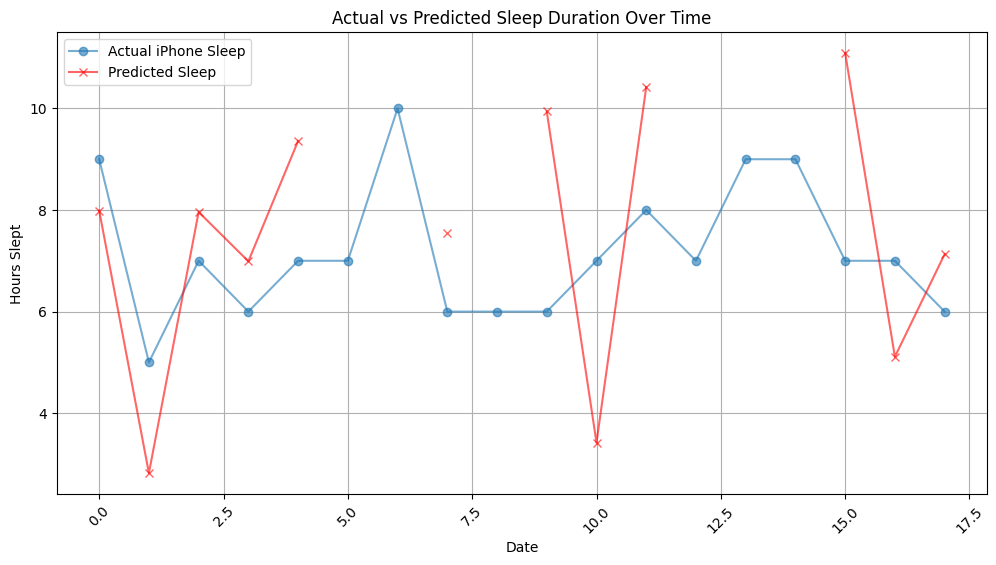

In [17]:
import matplotlib.pyplot as plt


# Extract Actual and Predicted Sleep Durations
actual_sleep = merged_sleep_df["iPhone Sleep Duration (hrs)"]
predicted_sleep = merged_sleep_df["Predicted Sleep Duration (hrs)"]

# Plot Actual vs Predicted Sleep
plt.figure(figsize=(12,6))
plt.plot(merged_sleep_df.index, actual_sleep, marker='o', linestyle='-', label="Actual iPhone Sleep", alpha=0.6)
plt.plot(merged_sleep_df.index, predicted_sleep, marker='x', linestyle='-', label="Predicted Sleep", alpha=0.6, color="red")

plt.xticks(rotation=45)

# Labels & Title
plt.xlabel("Date")
plt.ylabel("Hours Slept")
plt.title("Actual vs Predicted Sleep Duration Over Time")
plt.legend()
plt.grid(True)
plt.show()


**Normality Check**

In [18]:
import pandas as pd
import scipy.stats as stats

# Function to check normality using Shapiro-Wilk test
def check_normality(data):
    stat, p_value = stats.shapiro(data)
    return p_value > 0.05  # If p > 0.05, data is normally distributed

# Extract actual (iPhone) and predicted sleep durations
actual_sleep = merged_sleep_df["iPhone Sleep Duration (hrs)"].dropna()
predicted_sleep = merged_sleep_df["Predicted Sleep Duration (hrs)"].dropna()

# Ensure equal length by keeping only common dates
common_indices = actual_sleep.index.intersection(predicted_sleep.index)
actual_sleep = actual_sleep.loc[common_indices]
predicted_sleep = predicted_sleep.loc[common_indices]

# Check normality
actual_normal = check_normality(actual_sleep)
predicted_normal = check_normality(predicted_sleep)

if actual_normal and predicted_normal:
    print("The data is normally distributed.")
else:
    print("The data is NOT normally distributed.")


The data is normally distributed.


**Pearson's Correlation**

In [19]:
pearson_corr, p_value = stats.pearsonr(actual_sleep, predicted_sleep)
print(f"Pearson's Correlation Coefficient: {pearson_corr}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson's Correlation Coefficient: 0.38042056632266114
P-value: 0.22250292277424943
The correlation is not statistically significant.


**T-TEST**

In [20]:
ttest_stat, p_value = stats.ttest_ind(actual_sleep, predicted_sleep)
print(f"T-Test Statistic: {ttest_stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

T-Test Statistic: -0.8941475790768803
P-value: 0.3809209878241484
The difference in means is not statistically significant.


**MAE/RSME**

In [21]:
mae = mean_absolute_error(actual_sleep, predicted_sleep)
rmse = np.sqrt(mean_squared_error(actual_sleep, predicted_sleep))
mape = np.mean(np.abs((actual_sleep - predicted_sleep) / actual_sleep)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.1741666666666664
Root Mean Squared Error (RMSE): 2.4390725696460938


In [22]:
bias = predicted_sleep - actual_sleep
mean_bias = np.mean(bias)
std_bias = np.std(bias)
print(f"Mean Bias: {mean_bias:.3f}")
print(f"Standard Deviation of Bias: {std_bias:.3f}")

Mean Bias: 0.731
Standard Deviation of Bias: 2.327


# **Sleep Start/End Analysis**

**Normality Check**

In [23]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure timestamps are in datetime format
merged_sleep_df["iPhone Sleep Start"] = pd.to_datetime(merged_sleep_df["iPhone Sleep Start"])
merged_sleep_df["Predicted Sleep Start"] = pd.to_datetime(merged_sleep_df["Predicted Sleep Start"])
merged_sleep_df["iPhone Sleep End"] = pd.to_datetime(merged_sleep_df["iPhone Sleep End"])
merged_sleep_df["Predicted Sleep End"] = pd.to_datetime(merged_sleep_df["Predicted Sleep End"])

# Drop NaN values
valid_df = merged_sleep_df.dropna(subset=["iPhone Sleep Start", "Predicted Sleep Start", "iPhone Sleep End", "Predicted Sleep End"]).copy()

# Compute differences in HOURS
start_time_diff = (valid_df["iPhone Sleep Start"] - valid_df["Predicted Sleep Start"]).dt.total_seconds() / 3600
end_time_diff = (valid_df["iPhone Sleep End"] - valid_df["Predicted Sleep End"]).dt.total_seconds() / 3600

# Function to check normality using Shapiro-Wilk test
def check_normality(data):
    stat, p_value = stats.shapiro(data.dropna())  # Drop NaN before testing
    return p_value > 0.05  # If p > 0.05, data is normally distributed

# Check normality for start and end times
start_normal = check_normality(start_time_diff)
end_normal = check_normality(end_time_diff)

if start_normal and end_normal:
    print("The data is normally distributed.")
else:
    print("The data is NOT normally distributed.")

The data is normally distributed.


**Pearson's Correlation**

In [24]:
pearson_start_corr, pearson_start_p = stats.pearsonr(start_time_diff, end_time_diff)
pearson_end_corr, pearson_end_p = stats.pearsonr(end_time_diff, start_time_diff)
print(f"Pearson's Correlation Coefficient (Start): {pearson_start_corr}")
print(f"P-value (Start): {pearson_start_p}")
print(f"Pearson's Correlation Coefficient (End): {pearson_end_corr}")
print(f"P-value (End): {pearson_end_p}")
if pearson_start_p < 0.05:
    print("The correlation between start times is statistically significant.")
else:
    print("The correlation between start times is not statistically significant.")
if pearson_end_p < 0.05:
    print("The correlation between end times is statistically significant.")
else:
    print("The correlation between end times is not statistically significant.")

Pearson's Correlation Coefficient (Start): 0.9158426746903603
P-value (Start): 2.8827050764939704e-05
Pearson's Correlation Coefficient (End): 0.9158426746903603
P-value (End): 2.8827050764939704e-05
The correlation between start times is statistically significant.
The correlation between end times is statistically significant.


**T-Test**

In [25]:
t_test_start_stat, t_test_start_p = stats.ttest_rel(start_time_diff, end_time_diff)
t_test_end_stat, t_test_end_p = stats.ttest_rel(end_time_diff, start_time_diff)

print(f"T-Test Statistic (Start): {t_test_start_stat}")
print(f"P-value (Start): {t_test_start_p}")
print(f"T-Test Statistic (End): {t_test_end_stat}")
print(f"P-value (End): {t_test_end_p}")
if t_test_start_p < 0.05:
    print("The difference in start times is statistically significant.")
else:
    print("The difference in start times is not statistically significant.")
if t_test_end_p < 0.05:
    print("The difference in end times is statistically significant.")
else:
    print("The difference in end times is not statistically significant.")

T-Test Statistic (Start): 1.0408927657891653
P-value (Start): 0.3202632654220425
T-Test Statistic (End): -1.0408927657891653
P-value (End): 0.3202632654220425
The difference in start times is not statistically significant.
The difference in end times is not statistically significant.


**MAE/RMSE**

In [26]:
mae_start = mean_absolute_error(start_time_diff, np.zeros_like(start_time_diff))
rmse_start = np.sqrt(mean_squared_error(start_time_diff, np.zeros_like(start_time_diff)))

mae_end = mean_absolute_error(end_time_diff, np.zeros_like(end_time_diff))
rmse_end = np.sqrt(mean_squared_error(end_time_diff, np.zeros_like(end_time_diff)))
print(f"Mean Absolute Error (MAE) for Start Times: {mae_start}")
print(f"Root Mean Squared Error (RMSE) for Start Times: {rmse_start}")
print(f"Mean Absolute Error (MAE) for End Times: {mae_end}")
print(f"Root Mean Squared Error (RMSE) for End Times: {rmse_end}")

Mean Absolute Error (MAE) for Start Times: 4.5254305785228475
Root Mean Squared Error (RMSE) for Start Times: 5.4711578884305165
Mean Absolute Error (MAE) for End Times: 5.469042237107986
Root Mean Squared Error (RMSE) for End Times: 6.073034503643411


**BIAS**

In [27]:
mean_start_bias = np.mean(start_time_diff)
std_start_bias = np.std(start_time_diff)

mean_end_bias = np.mean(end_time_diff)
std_end_bias = np.std(end_time_diff)
print(f"Mean Bias for Start Times: {mean_start_bias}")
print(f"Standard Deviation for Start Times: {std_start_bias}")
print(f"Mean Bias for End Times: {mean_end_bias}")
print(f"Standard Deviation for End Times: {std_end_bias}")

Mean Bias for Start Times: -1.0909139879127547
Standard Deviation for Start Times: 5.361294182481666
Mean Bias for End Times: -1.8212138658989583
Standard Deviation for End Times: 5.793524673038059


**Regression**

In [28]:
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X_start = valid_df["Predicted Sleep Start"].astype(int).values.reshape(-1, 1)  # Convert datetime to integer timestamp
y_start = valid_df["iPhone Sleep Start"].astype(int).values.reshape(-1, 1)

X_end = valid_df["Predicted Sleep End"].astype(int).values.reshape(-1, 1)
y_end = valid_df["iPhone Sleep End"].astype(int).values.reshape(-1, 1)

# Fit regression models
model_start = LinearRegression().fit(X_start, y_start)
model_end = LinearRegression().fit(X_end, y_end)

# Get coefficients
r2_start = model_start.score(X_start, y_start)
r2_end = model_end.score(X_end, y_end)

coef_start = model_start.coef_[0][0]
intercept_start = model_start.intercept_[0]

coef_end = model_end.coef_[0][0]
intercept_end = model_end.intercept_[0]

# Print results
print(f"Regression Equation for Sleep Start: Actual = {coef_start:.4f} * Predicted + {intercept_start:.4f}")
print(f"R² for Sleep Start Prediction: {r2_start:.4f}")

print(f"Regression Equation for Sleep End: Actual = {coef_end:.4f} * Predicted + {intercept_end:.4f}")
print(f"R² for Sleep End Prediction: {r2_end:.4f}")


Regression Equation for Sleep Start: Actual = 0.9901 * Predicted + 17251251210088960.0000
R² for Sleep Start Prediction: 0.9986
Regression Equation for Sleep End: Actual = 0.9868 * Predicted + 22974857903165952.0000
R² for Sleep End Prediction: 0.9984
